In [1]:
import json
import sys
import glob
import os
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib
import pandas as pd
import scipy.stats as stats
import sklearn.metrics as sklm

sys.path.append("..")
from util import io, plot, simprop

%matplotlib inline

/home/vsip/soft/miniconda2/envs/py36/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


embedWindow(verbose=True): could not load k3d module, try:
> pip install k3d      # and if necessary:
> conda install nodejs


## Load data

In [2]:
# Surgeries
with open("../data/surgeries.vep.json") as fh:
    surgeries = json.load(fh)['data']
    surgeries = {int(k[2:5]): v for k, v in surgeries.items()}
    
region_names = list(np.genfromtxt("../data/conn/region_names.vep.txt", usecols=(0,), dtype=str))    

In [3]:
# Example
sid, rid = 17, 3
nreg = 162

data = io.rload(f"../run/solo/INC/vep/id{sid:03d}/input/r{rid:02d}_all.R")
wpre = data['w']
q = [data['q11'], data['q12'], data['qa21'], data['qa22']]
obsmask = np.zeros(nreg, dtype=bool)
obsmask[np.array(data['reg_sz'], dtype=int)] = 1
obsmask[np.array(data['reg_ns'], dtype=int)] = 1
tlim = data['t_lim']
    
chains = [1, 2]
resfiles = [f"../run/solo/INC/vep/id{sid:03d}/output/r{rid:02d}_all/chain_{ch}.csv" for ch in chains]
statuses = [f"../run/solo/INC/vep/id{sid:03d}/output/r{rid:02d}_all/chain_{ch}.status" for ch in chains]
res = io.parse_csv([r for r, s in zip(resfiles, statuses) if int(open(s).read().strip())])
cinf = res['c']
nreg = cinf.shape[1]

In [4]:
RESECTION_THRESHOLD = 0.501

# Pre-op and post-op seizure
resection = surgeries[sid]['resection']
resected = [region_names.index(regname) for regname, fraction in resection.items()
            if fraction > RESECTION_THRESHOLD]
if len(resected) == 0:
    resected = [region_names.index(max(resection, key=resection.get))]

wpost = np.copy(wpre)
for reg in resected:
    wpost[reg, :] = 0
    wpost[:, reg] = 0

nsamples, nreg = cinf.shape
tpre = np.zeros((nsamples, nreg))
tpost = np.zeros((nsamples, nreg))
for i in range(nsamples):
    tpre[i, :] = simprop.prop(cinf[i], wpre, q)
    tpost[i, :] = simprop.prop(cinf[i], wpost, q)
tpost[:, resected] = np.inf

In [5]:
def recprob(tsamples, nt, tlim, resected=None):
    nreg = tsamples.shape[1]
    ts = np.linspace(0, tlim, nt, endpoint=True)
    psz = np.zeros((nreg, nt))
    for i in range(nt):
        psz[:, i] = np.mean(tsamples < ts[i], axis=0)
    if resected is not None:
        for reg in resected:
            psz[reg, :] = np.nan
    return psz

nt = 1000
rp_pre = recprob(tpre, nt, tlim)
rp_post = recprob(tpost, nt, tlim, resected)

In [6]:
# Group data

df = pd.read_pickle("../run/solo/df-virtual-resection.pkl")
df = df[df.onset == 'INC']

df['nsz_red'] = (df.nsz_pre - df.nsz_post) / df.nsz_pre
df['avg_psz_red'] = (df.avg_psz_pre - df.avg_psz_post) / df.avg_psz_pre

In [31]:
# Group
dfg = df.groupby(['onset', 'atlas', 'subject']).agg({'engel': 'first', 'nresected': 'first',
                                                      # 'nsz_pre': 'mean', 
                                                      'nsz_post': ['mean', 'max'], 
                                                      'nsz_red': ['mean', 'min'],
                                                       # 'avg_psz_pre': 'mean',
                                                      'avg_psz_post': ['mean', 'max'],
                                                      'avg_psz_red': ['mean', 'min']})

### Load inference data

In [23]:
onset = 'INC'
CHAINS = [1,2]
nreg = 162
rows = []

for sid, surgery in surgeries.items():     
    subject = f"id{sid:03d}"
    res_dir = f"../run/solo/{onset}/vep/{subject}/output/"
    rec_dirs = glob.glob(os.path.join(res_dir, "r*_all/"))

    resection = surgery['resection']
    frac_resected = [resection.get(region_names[i], 0.0) for i in range(nreg)]
    is_resected = np.array(frac_resected) > RESECTION_THRESHOLD
    if not np.any(is_resected):
        is_resected[np.argmax(frac_resected)] = True
    
    for rec_dir in rec_dirs:
        rid = int(rec_dir[-7:-5])

        indata = io.rload(f"../run/solo/{onset}/vep/{subject}/input/r{rid:02d}_all.R")
        reg_sz = list(indata['reg_sz'].astype(int))
        reg_ns = list(indata['reg_ns'].astype(int))
        reg_obs = reg_sz + reg_ns

        resfiles = [os.path.join(rec_dir, f"chain_{chain}.csv") for chain in CHAINS]
        statuses = [os.path.join(rec_dir, f"chain_{chain}.status") for chain in CHAINS]
        res = io.parse_csv([r for r, s in zip(resfiles, statuses) if int(open(s).read().strip())])
        pez = np.mean(res['c'] > 2.0, axis=0)
    
        for i in range(nreg):
            rows.append(OrderedDict(
                onset=onset,
                subject=subject,
                rid=rid,
                region=i,

                observed=(i in reg_obs),
                seizing=(i in reg_sz),
                fracsz=(len(reg_sz) / len(reg_obs)),

                pez=pez[i],
                resection=frac_resected[i],
                is_resected=is_resected[i],
                engel=surgery['engel']
            ))
            
dfr = pd.DataFrame(rows)
dfrg = dfr.groupby(['onset', 'subject', 'region']).agg(
                  {'observed': 'any', 'seizing': 'any', 'fracsz': 'first',
                   'pez': 'mean',  'resection': 'first', 'is_resected': 'first',
                   'engel': 'first'}).reset_index()

## Main figure

In [24]:
import itertools
def flip(items, ncol):
    return itertools.chain(*[items[i::ncol] for i in range(ncol)])

1 | 0.05 | 0.3709677419354839 | 0.27710843373493976
1 | 0.1 | 0.6521739130434783 | 0.18072289156626506
2 | 0.05 | 0.45454545454545453 | 0.45454545454545453
2 | 0.1 | 0.6666666666666666 | 0.36363636363636365
3 | 0.05 | 0.05263157894736842 | 0.08695652173913043
3 | 0.1 | 0.125 | 0.043478260869565216
4 | 0.05 | 0.4117647058823529 | 0.28
4 | 0.1 | 0.42857142857142855 | 0.12


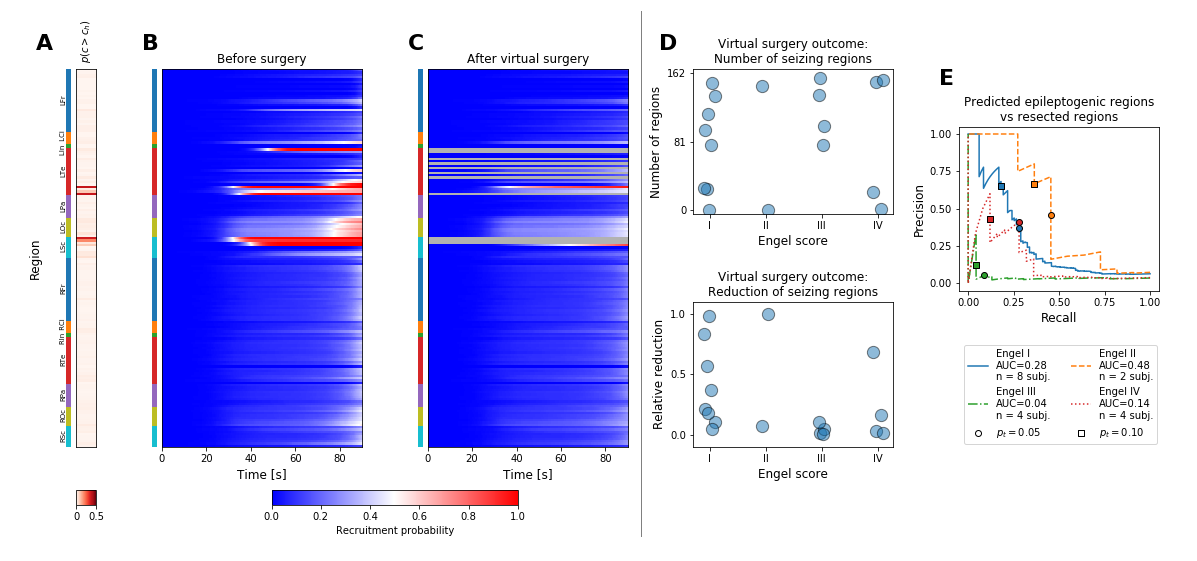

In [137]:
EZ_THRESHOLD = 2.0

cmap = matplotlib.cm.get_cmap('bwr')
cmap.set_bad(color='0.7')

fig = plt.figure(figsize=(16, 7.3))
gs = gridspec.GridSpec(2, 5, width_ratios=[0.1, 1, 1, 1, 1], height_ratios=[1, 0.04], wspace=0.4, hspace=0.22,
                       left=0.04, right=0.98, bottom=0.06, top=0.89)

# Panel A: Excitabilities
axa = plt.subplot(gs[0, 0])
im = plt.imshow(np.mean(cinf > EZ_THRESHOLD, axis=0)[:, None], origin='upper', vmin=0, vmax=0.5, cmap='Reds',
                extent=[0, 1, nreg, 0], aspect='auto')
plt.xticks([]); plt.yticks([]); plt.xlim([0, 1])
plt.title("$p(c > c_h)$", fontsize=10, rotation='vertical', ha='center', va='bottom')
plot.add_brain_regions(axa, pad=5, width=5, coord='display', labels=True)
plt.ylabel("Region\n\n", fontsize=12)

# Colorbar
axcb = plt.subplot(gs[1, 0])
cb1 = plt.colorbar(im, cax=axcb, ticks=[0., 0.5], orientation='horizontal', )
axcb.set_xticklabels(["0", "0.5"])    

# Panel B: Pre-op dynamics
axb = plt.subplot(gs[0, 1])
imb = plt.imshow(rp_pre, origin='upper', extent=[0, tlim, nreg, 0], cmap=cmap, vmin=0, vmax=1, aspect='auto')
plt.yticks([]); plt.xlim([0, tlim])
plt.xlabel("Time [s]", fontsize=12)
plot.add_brain_regions(axb, pad=5, width=5, coord='display', labels=False)
plt.title("Before surgery")

# Panel C: Post-op dynamics
axc = plt.subplot(gs[0, 2])
imc = plt.imshow(rp_post, origin='upper', extent=[0, tlim, nreg, 0], cmap=cmap, vmin=0, vmax=1, aspect='auto')
plt.yticks([]); plt.xlim([0, tlim])
plt.xlabel("Time [s]", fontsize=12)
plot.add_brain_regions(axc, pad=5, width=5, coord='display', labels=False)
plt.title("After virtual surgery")

# Colorbar
gs2 = gridspec.GridSpecFromSubplotSpec(1, 3, gs[1, 1:3], width_ratios=[1, 3, 1])
axcb = plt.subplot(gs2[1])
cb2 = plt.colorbar(imb, cax=axcb, orientation='horizontal', label="Recruitment probability")

# Panel D: Statistics
gsd = gridspec.GridSpecFromSubplotSpec(2, 1, gs[0, 3], hspace=0.6)

nsub = len(dfg)

axd1 = plt.subplot(gsd[0])
np.random.seed(47)
plt.scatter(dfg.engel['first'] + np.random.uniform(-0.1, 0.1, nsub), dfg.nsz_post['mean'].to_numpy(),
            s=150, alpha=0.5, edgecolor='k')
plt.xticks([1, 2, 3, 4], ["I", "II", "III", "IV"])
plt.xlabel("Engel score", fontsize=12)
plt.ylim(-5, nreg+5)
plt.yticks([0, 81, 162])
plt.ylabel("Number of regions", fontsize=12)
plt.title("Virtual surgery outcome:\nNumber of seizing regions")


axd2 = plt.subplot(gsd[1])
np.random.seed(47)
plt.scatter(dfg.engel['first'] + np.random.uniform(-0.1, 0.1, nsub), dfg.nsz_red['mean'].to_numpy(),
            s=150, alpha=0.5, edgecolor='k')
plt.xticks([1, 2, 3, 4], ["I", "II", "III", "IV"])
plt.xlabel("Engel score", fontsize=12)
plt.ylim(-0.1, 1.1)
plt.yticks([0, 0.5, 1.0])
plt.ylabel("Relative reduction", fontsize=12)
plt.title("Virtual surgery outcome:\nReduction of seizing regions")


# Panel E: Precision-Recall
gse = gridspec.GridSpecFromSubplotSpec(4, 1, gs[0, 4], height_ratios=[0.5, 2, 1, 0.5])
# gse = gridspec.GridSpecFromSubplotSpec(4, 1, gs[0, 4], height_ratios=[1, 1, 1, 0.5])
axe = plt.subplot(gse[1])
plt.title("Predicted epileptogenic regions\nvs resected regions")
thrs = [0.05, 0.1]
markers = ['o', 's']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
linestyles = ['-', '--', '-.', ':']
for i, (engel, label) in enumerate(zip([1,2,3,4], ["I", "II", "III", "IV"])):
    dff = dfrg[dfrg.engel == engel]
    nsubjects = len(dff[['subject']].drop_duplicates())
    prec, recall, threshold = sklm.precision_recall_curve(dff.is_resected, dff.pez)
    auc = sklm.auc(recall, prec)
    plt.plot(recall, prec, label=f"Engel {label}\nAUC={auc:4.2f}\nn = {nsubjects} subj.", 
             color=colors[i], ls=linestyles[i])
    for thr, marker in zip(thrs, markers):
        j = np.where(threshold >= thr)[0][0]
        plt.scatter(recall[j], prec[j], marker=marker, color=colors[i], edgecolor='k',
                    zorder=5)
        print(f"{engel} | {thr} | {prec[j]} | {recall[j]}")

plt.xticks([0, 0.25, 0.5, 0.75, 1.0])
plt.yticks([0, 0.25, 0.5, 0.75, 1.0])
plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)

# Legend
for thr, marker in zip(thrs, markers):
    plt.scatter([], [], marker=marker, color='w', edgecolor='k',
                label=f"$p_t = {thr:0.2f}$")
handles, labels = axe.get_legend_handles_labels()
plt.legend(flip(handles, 2), flip(labels, 2), loc='upper left', bbox_to_anchor=(0, -0.3), ncol=2)
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Grid
bg = plot.Background(visible=False)
bg.vline(x=0.53)
plot.add_panel_letters(fig, [axa, axb, axc, axd1, axe], fontsize=22,
                       xpos=[-2, -0.1, -0.1, -0.17, -0.1], ypos=[1.05, 1.05, 1.05, 1.13, 1.25])

plt.savefig("img/virtual-resection.pdf", dpi=600)

## Results

In [114]:
dfa = dfg[dfg.engel['first'].isin([1,2])]
dfb = dfg[dfg.engel['first'].isin([3,4])]
stats.mannwhitneyu(dfa.nsz_red['mean'], dfb.nsz_red['mean'], alternative='two-sided')

# ----------------------------------------------

## Alternative virtual surgery analysis

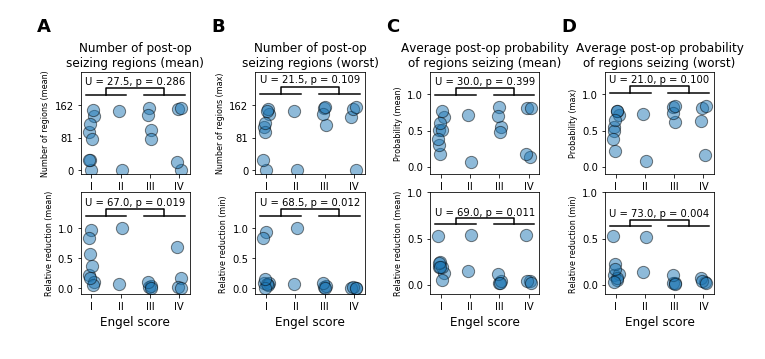

In [156]:
def plot_outcome(ax, dfg, variable, aggreg, ylabel, yticks, ylim):
    nsub = len(dfg)
    np.random.seed(47)
    
    plt.sca(ax)
    plt.scatter(dfg.engel['first'] + np.random.uniform(-0.1, 0.1, nsub), dfg[variable][aggreg],
                s=150, alpha=0.5, edgecolor='k')

    plt.xticks([1, 2, 3, 4], ["I", "II", "III", "IV"])
    plt.xlabel("Engel score", fontsize=12)
    plt.ylim(ylim)
    plt.yticks(yticks)
    plt.ylabel(ylabel, fontsize=8)
    
    # Statistics
    dfa = dfg[dfg.engel['first'].isin([1, 2])]
    dfb = dfg[dfg.engel['first'].isin([3,4])]
    res = stats.mannwhitneyu(dfa[variable][aggreg], dfb[variable][aggreg], alternative='two-sided')
    
    ypos = 1.2 * np.max(dfg[variable][aggreg])
    plt.plot([0.8, 2.2], [ypos, ypos], color='k')
    plt.plot([2.8, 4.2], [ypos, ypos], color='k')
    plt.plot([1.5, 1.5, 3.5, 3.5], [ypos, 1.1*ypos, 1.1*ypos, ypos], color='k')
    plt.text(2.5, 1.12*ypos, f"U = {res.statistic}, p = {res.pvalue:.3f}", ha='center', va='bottom')
    
    return ax

    
fig = plt.figure(figsize=(10, 4.5))
gs = gridspec.GridSpec(2, 4, wspace=0.6, hspace=0.18, left=0.07, right=0.95, top=0.81)

ax1 = plot_outcome(plt.subplot(gs[0, 0]), dfg, 'nsz_post', 'mean', "Number of regions (mean)", [0, 81, 162], [-10, 244])
plt.title("Number of post-op\nseizing regions (mean)")
ax2 = plot_outcome(plt.subplot(gs[1, 0]), dfg, 'nsz_red', 'mean', "Relative reduction (mean)", [0, 0.5, 1], [-0.1, 1.6])

ax3 = plot_outcome(plt.subplot(gs[0, 1]), dfg, 'nsz_post', 'max', "Number of regions (max)", [0, 81, 162], [-10, 244])
plt.title("Number of post-op\nseizing regions (worst)")
ax4 = plot_outcome(plt.subplot(gs[1, 1]), dfg, 'nsz_red', 'min', "Relative reduction (min)", [0, 0.5, 1], [-0.1, 1.6])

ax5 = plot_outcome(plt.subplot(gs[0, 2]), dfg, 'avg_psz_post', 'mean', "Probability (mean)", [0, 0.5, 1], [-0.1, 1.3])
plt.title("Average post-op probability\nof regions seizing (mean)")
ax6 = plot_outcome(plt.subplot(gs[1, 2]), dfg, 'avg_psz_red', 'mean', "Relative reduction (mean)", [0, 0.5, 1], [-0.1, 1.0])

ax7 = plot_outcome(plt.subplot(gs[0, 3]), dfg, 'avg_psz_post', 'max', "Probability (max)", [0, 0.5, 1], [-0.1, 1.3])
plt.title("Average post-op probability\nof regions seizing (worst)")
ax8 = plot_outcome(plt.subplot(gs[1, 3]), dfg, 'avg_psz_red', 'min', "Relative reduction (min)", [0, 0.5, 1], [-0.1, 1.0])


bg = plot.Background(visible=False)
plot.add_panel_letters(fig, axes=[ax1, ax3, ax5, ax7], xpos=-0.4, ypos=1.4, fontsize=18)

plt.savefig("./img/virtual-resection-supp.pdf")

## Relation of the resection size and surgery outcome

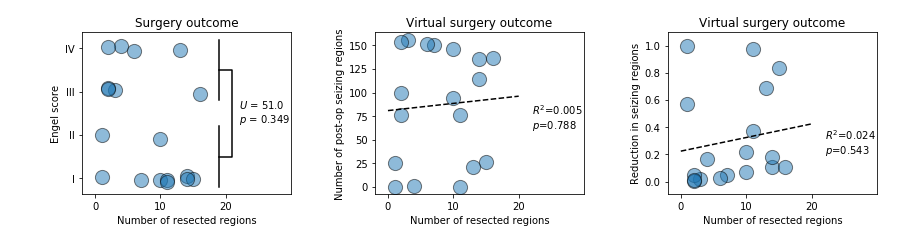

In [213]:
nsub = len(dfg)

variables = ['engel', 'nsz_post', 'nsz_red']
ylabels = ['Engel score', 'Number of post-op seizing regions', 'Reduction in seizing regions']
aggregs = ['first', 'mean', 'mean']
jitters = [True, False, False]
tests = ['MW', 'LR', 'LR']
titles = ["Surgery outcome", "Virtual surgery outcome", "Virtual surgery outcome"]

plt.figure(figsize=(12, 3))
gs = gridspec.GridSpec(1, 3, wspace=0.4, left=0.06, right=0.98, bottom=0.15, top=0.9)
for i in range(len(variables)):
    var = variables[i]
    aggreg = aggregs[i]
               
    plt.subplot(gs[i])
    plt.title(titles[i])
    
    jitter = np.zeros(nsub)
    if jitters[i]:
        jitter = np.random.uniform(-0.1, 0.1, nsub)
    
    
    plt.scatter(dfg.nresected['first'], dfg[var][aggreg] + jitter, s=200, alpha=0.5, edgecolor='k')
    plt.ylabel(ylabels[i])
    plt.xlabel("Number of resected regions")
    
    if tests[i] == 'LR':
        slope, intercept, rval, pval, stderr = stats.linregress(dfg.nresected['first'], dfg[var][aggreg])
        x = np.linspace(0, 20)
        plt.plot(x, intercept+x*slope, 'k--')
        plt.text(22, 0.9*(intercept+20*slope), f"$R^2$={rval**2:.3f}\n$p$={pval:.3f}", va='top')
    elif tests[i] == 'MW':
        dfa = dfg[dfg.engel['first'].isin([1,2])]
        dfb = dfg[dfg.engel['first'].isin([3,4])]
        res = stats.mannwhitneyu(dfa.nresected['first'], dfb.nresected['first'], alternative='two-sided')
        plt.text(22, 2.5, f"$U$ = {res.statistic}\n$p$ = {res.pvalue:.3f}", ha='left', va='center')
        
        xpos = 19
        plt.plot([xpos, xpos], [0.8, 2.2], color='k')
        plt.plot([xpos, xpos], [2.8, 4.2], color='k')
        plt.plot([xpos, 1.1*xpos, 1.1*xpos, xpos], [1.5, 1.5, 3.5, 3.5], color='k')
        
    plt.xlim(-2, 30)
    plt.xticks([0, 10, 20])
    if i == 0:
        plt.yticks([1, 2, 3, 4], ["I", "II", "III", "IV"])
    
bg = plot.Background(visible=False)
plt.savefig("img/surgery-num-of-resected.pdf")